# Evaluation of Experiments

In [1]:
import os
import json

import numpy as np
import pylab as plt
import pandas as pd
import yaml

from tqdm.auto import tqdm
from pathlib import Path
from omegaconf import OmegaConf

In [2]:
def load_results(root_path, model_names, model_labels=None):
    model_labels = model_names if model_labels == None else model_labels
    results = {mn:{} for mn in model_labels}

    for i, model_name in enumerate(model_names):
        label = model_labels[i]
        paths = sorted(list(root_path.glob(model_name+"*")))
        for path in tqdm(paths):
            with open(path / 'results_final.json', 'r') as f:
                run_results = json.load(f)
            with open(path / '.hydra/config.yaml') as g:
                conf = yaml.load(g, Loader=yaml.FullLoader)

            results[label][str(path)[-1]] = {'results': run_results, 'args': conf}
    return results

def average_results(results, model_labels, metrics):
    # Calculate average test metrics and stds aswell as train metrics and stds for each model
    avg_results = {ml : {met : {} for met in metrics} for ml in model_labels}
    stds = {ml : {met : {} for met in metrics} for ml in model_labels}

    # Extract average test metrics per cycle
    for ml, runs in results.items():
        for metric in metrics:
            all_values = []
            for _, run in runs.items():
                history = run['results']
                values = []
                if metric in history['test_history'][0]:
                    for h in history['test_history']:
                        values.append(h[metric])
                else:
                    for h in history['train_history']:
                        values.append(h[metric])
                all_values.append(values)
            avg_results[ml][metric] = np.mean(np.array(all_values), axis=0)
            stds[ml][metric] = np.std(np.array(all_values), axis=0)

    return avg_results, stds

In [3]:
model_names = ['RES-DET', 'RES-MIX', 'RES-LS']
model_labels = ['Baseline', 'Mixup', 'Label-Smoothing'] 
# possible metrics = ['test_acc1', 'test_prec', 'test_loss', 'test_nll', 'test_tce', 'test_mce','test_SVHN_entropy_auroc', 'test_SVHN_conf_auroc', 'test_SVHN_entropy_aupr', 'test_SVHN_conf_aupr']
metrics = ['test_acc1', 'test_prec', 'test_loss', 'test_nll', 'test_tce', 'test_mce']
root_path = Path('./results_/')

results = load_results(root_path=root_path,
                       model_names=model_names,
                       model_labels=model_labels)

avg_results, stds = average_results(results, model_labels, metrics)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
dic = {}

for ml in model_labels:
    dic[ml] = {}
    for metric in metrics:
        dic[ml][metric] = f"{avg_results[ml][metric][-1]:.4f} +/- {stds[ml][metric][-1]:.4f}"

pd.DataFrame(dic).T

,test_acc1,test_prec,test_loss,test_nll,test_tce,test_mce
Baseline,95.3233 +/- 0.1087,0.9533 +/- 0.0011,0.1924 +/- 0.0044,0.1924 +/- 0.0044,0.0290 +/- 0.0013,0.0242 +/- 0.0013
Mixup,96.0167 +/- 0.0899,0.9603 +/- 0.0010,0.2092 +/- 0.0007,0.2092 +/- 0.0007,0.0802 +/- 0.0026,0.0330 +/- 0.0005
Label-Smoothing,95.5033 +/- 0.1533,0.9552 +/- 0.0016,0.4190 +/- 0.0047,0.1958 +/- 0.0048,0.0401 +/- 0.0013,0.0242 +/- 0.0007


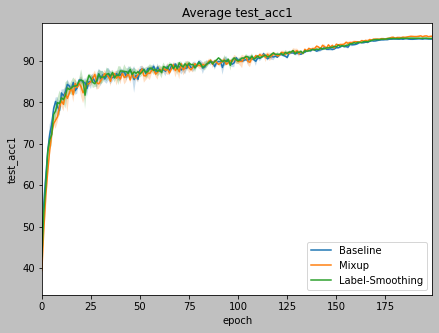

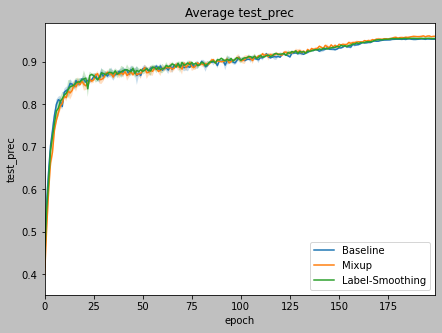

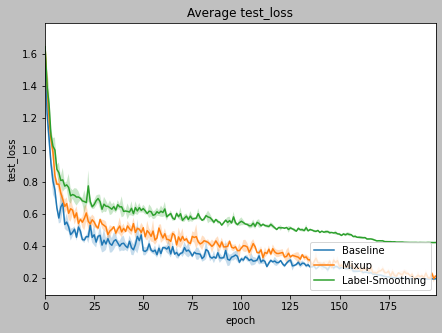

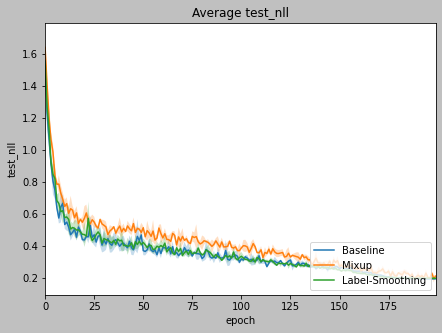

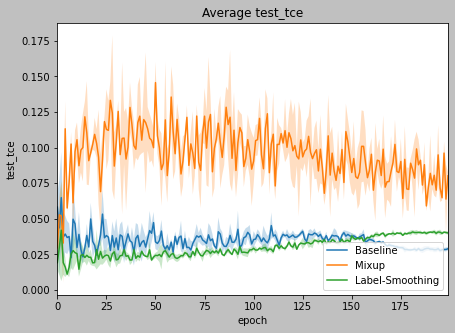

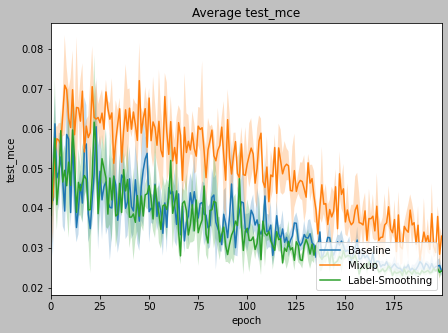

In [5]:
for metric in metrics:
    plt.figure(figsize=(7,5), facecolor='silver')
    for i, ml in enumerate(model_labels):
        plt.plot(avg_results[ml][metric], label=ml)
        plt.fill_between(
            x=[i for i in range(len(avg_results[ml][metric]))], 
            y1=avg_results[ml][metric]+abs(stds[ml][metric]), 
            y2=avg_results[ml][metric]-abs(stds[ml][metric]),
            alpha=0.25,
            edgecolor=None, 
            )
        plt.legend(loc='lower right')
        plt.title("Average "+metric)
        plt.xlim(0, len(avg_results[ml][metric])-1)
        plt.xlabel('epoch')
        plt.ylabel(metric)        
    plt.show()